In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist

from matplotlib import pyplot as plt

import numpy as np

In [2]:
train_loader, test_loader = mnist()

In [3]:
class Net(nn.Module):
    def __init__(self, fc_size=128, act='sigmoid', lr=0.001, log_softmax=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, fc_size)
        self.fc2 = nn.Linear(fc_size, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=lr)
        if 'sigmoid'==act:
            self.act = torch.sigmoid
        else:
            self.act = torch.relu
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models, verbose=True):    
    correct = [0]*len(models)
    for batch_idx, (data, target) in enumerate(train_loader):
        for i, model in enumerate(models):
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct[i] += pred.eq(target.data.view_as(pred)).sum()
            loss.backward()
            model.optim.step()
            
        if True==verbose and batch_idx % 200 == 0:
            line = f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLosses '
            losses = ' '.join([f'{i}: {m._loss.item():.6f}' for i, m in enumerate(models)])
            print(line + losses)        
            
    train_accuracy = [float(c) / len(train_loader.dataset) for c in correct]
        
    train_loss = [m._loss.item() for m in models]
    if True==verbose:
        batch_idx += 1
        line = f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLosses '    
        losses = ' '.join([f'{i}: {m._loss.item():.6f}' for i, m in enumerate(models)])
        print(line + losses)
    
    return train_loss, train_accuracy

In [5]:
avg_lambda = lambda l: f'Loss: {l:.4f}'
acc_lambda = lambda c, p: f'Accuracy: {c}/{len(test_loader.dataset)} ({p:.0f}%)'
line = lambda i, l, c, p: f'{i}: ' + avg_lambda(l) + '\t' + acc_lambda(c, p)

def test(models, verbose=True):
    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in test_loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, reduction='sum').item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).sum()
    
    for i in range(len(models)):
        test_loss[i] /= len(test_loader.dataset)
    test_accuracy = [float(c) / len(test_loader.dataset) for c in correct]
    if True==verbose:        
        lines = '\n'.join([line(i, test_loss[i], correct[i], test_accuracy[i]*100) for i in range(len(models))]) + '\n'
        report = 'Test set:\n' + lines    
        print(report)
    
    return test_loss, test_accuracy

In [29]:
models_1L = [Net(fc_size=128, act='sigmoid', lr=1, log_softmax=True), Net(fc_size=28*28, act='sigmoid', lr=1, log_softmax=True)]

In [30]:
n_epochs = 600

In [31]:
train_loss_history_1L = []
train_accuracy_history_1L =[]
test_loss_history_1L = []
test_accuracy_history_1L = []
for epoch in range(1, n_epochs+1):    
    train_loss, train_accuracy = train(epoch, models_1L, verbose=False)
    train_loss_history_1L.append(train_loss)
    train_accuracy_history_1L.append(train_accuracy)
    test_loss, test_accuracy = test(models_1L, verbose=False)
    test_loss_history_1L.append(test_loss)    
    test_accuracy_history_1L.append(test_accuracy)

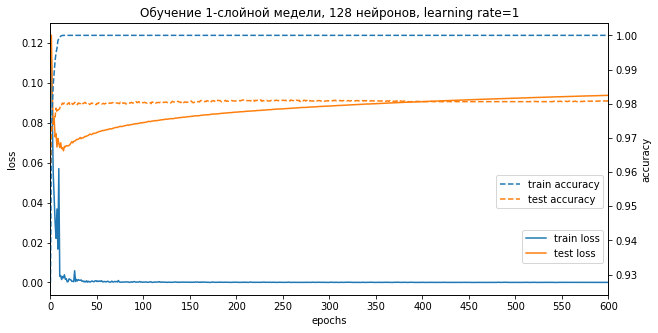

In [71]:
fog, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(range(1,n_epochs+1), [loss[0] for loss in train_loss_history_1L], label='train loss')
ax1.plot(range(1,n_epochs+1), [loss[0] for loss in test_loss_history_1L], label='test loss')

ax2 = ax1.twinx()
ax2.plot(range(1,n_epochs+1), [acc[0] for acc in train_accuracy_history_1L], label='train accuracy', ls='--')
ax2.plot(range(1,n_epochs+1), [acc[0] for acc in test_accuracy_history_1L], label='test accuracy', ls='--')

ax1.legend(loc='lower right', bbox_to_anchor=(0.5, 0.1, 0.5, 0.5))
ax2.legend(loc='lower right', bbox_to_anchor=(0.5,0.3, 0.5, 0.5))
ax1.set_title('Обучение 1-слойной медели, 128 нейронов, learning rate=1', fontsize=12);
ax1.set_xlim(1,n_epochs);
ax1.set_xticks(range(0,n_epochs+1,50));

ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.set_ylabel('accuracy');

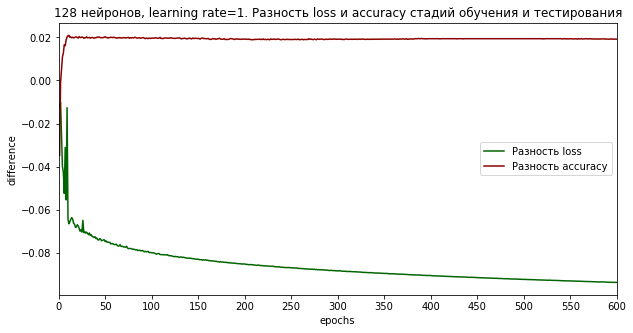

In [72]:
fog, ax = plt.subplots(figsize=(10,5))

ax.plot(range(1,n_epochs+1), [train_loss[0]-test_loss[0] for test_loss,train_loss in zip(test_loss_history_1L, train_loss_history_1L)], label='Разность loss', ls='-', color='darkgreen')
ax.plot(range(1,n_epochs+1), [train_acc[0]-test_acc[0] for test_acc,train_acc in zip(test_accuracy_history_1L, train_accuracy_history_1L)], label='Разность accuracy', ls='-', color='darkred')
ax.set_xlim(1,n_epochs);
ax.set_xticks(range(0,n_epochs+1,50));

ax.set_title('128 нейронов, learning rate=1. Разность loss и accuracy стадий обучения и тестирования', fontsize=12);
ax.legend();

ax.set_xlabel('epochs');
ax.set_ylabel('difference');

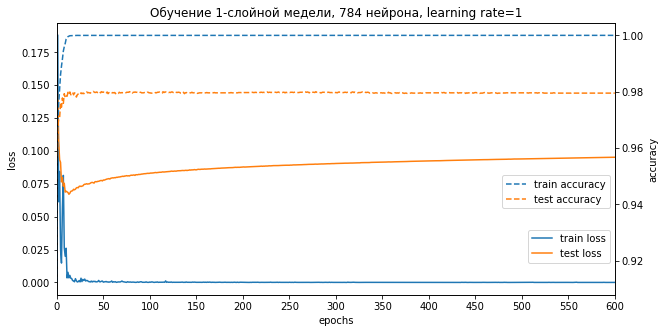

In [77]:
fog, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(range(1,n_epochs+1), [loss[1] for loss in train_loss_history_1L], label='train loss')
ax1.plot(range(1,n_epochs+1), [loss[1] for loss in test_loss_history_1L], label='test loss')

ax2 = ax1.twinx()
ax2.plot(range(1,n_epochs+1), [acc[1] for acc in train_accuracy_history_1L], label='train accuracy', ls='--')
ax2.plot(range(1,n_epochs+1), [acc[1] for acc in test_accuracy_history_1L], label='test accuracy', ls='--')

ax1.legend(loc='lower right', bbox_to_anchor=(0.5, 0.1, 0.5, 0.5))
ax2.legend(loc='lower right', bbox_to_anchor=(0.5, 0.3, 0.5, 0.5))
ax1.set_title('Обучение 1-слойной медели, 784 нейрона, learning rate=1', fontsize=12);
ax1.set_xlim(1,n_epochs);
ax1.set_xticks(range(0,n_epochs+1,50));

ax1.set_xlabel('epochs');
ax1.set_ylabel('loss');
ax2.set_ylabel('accuracy');

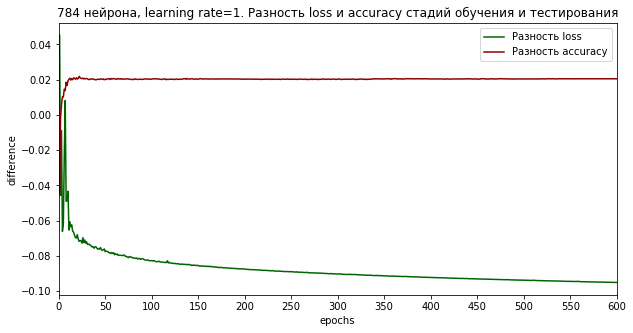

In [74]:
fog, ax = plt.subplots(figsize=(10,5))

ax.plot(range(1,n_epochs+1), [train_loss[1]-test_loss[1] for test_loss,train_loss in zip(test_loss_history_1L, train_loss_history_1L)], label='Разность loss', ls='-', color='darkgreen')
ax.plot(range(1,n_epochs+1), [train_acc[1]-test_acc[1] for test_acc,train_acc in zip(test_accuracy_history_1L, train_accuracy_history_1L)], label='Разность accuracy', ls='-', color='darkred')
ax.set_xlim(1,n_epochs);
ax.set_xticks(range(0,n_epochs+1,50));

ax.set_title('784 нейрона, learning rate=1. Разность loss и accuracy стадий обучения и тестирования', fontsize=12);
ax.legend();

ax.set_xlabel('epochs')
ax.set_ylabel('difference');

### Однослойные модели с разным количеством слоёв - 128 и 784.
### Обе модели показали примерно одинаковую точность распознавания - около 98%.
### Обе модели начали переобучаться примерно с 15-ой эпохи - начался рост функции потерь на тестовой выборке.

In [36]:
class Net_2L(nn.Module):
    def __init__(self, fc1_size=128, fc2_size=64, act='sigmoid', lr=0.1, log_softmax=True):
        super(Net_2L, self).__init__()
        self.fc1 = nn.Linear(28*28, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=lr)
        if 'sigmoid'==act:
            self.act = torch.sigmoid
        else:
            self.act = torch.relu
        
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [37]:
models_2L = [Net_2L(fc1_size=128, fc2_size=32, act='sigmoid', lr=1, log_softmax=True), Net_2L(fc1_size=28*28, fc2_size=128, act='sigmoid', lr=1, log_softmax=True)]

In [38]:
n_epochs = 600

In [39]:
train_loss_history_2L = []
train_accuracy_history_2L =[]
test_loss_history_2L = []
test_accuracy_history_2L = []
for epoch in range(1, n_epochs+1):    
    train_loss, train_accuracy = train(epoch, models_2L, verbose=False)
    train_loss_history_2L.append(train_loss)
    train_accuracy_history_2L.append(train_accuracy)
    test_loss, test_accuracy = test(models_2L, verbose=False)
    test_loss_history_2L.append(test_loss)    
    test_accuracy_history_2L.append(test_accuracy)

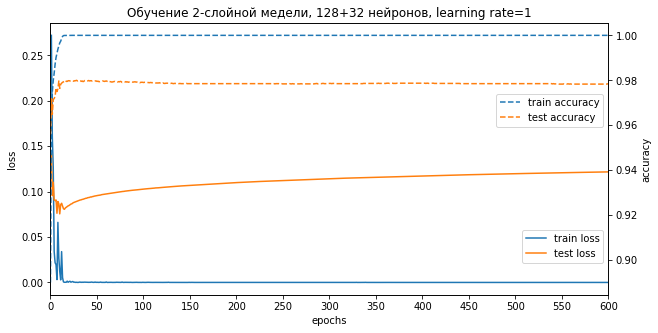

In [78]:
fog, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(range(1,n_epochs+1), [loss[0] for loss in train_loss_history_2L], label='train loss')
ax1.plot(range(1,n_epochs+1), [loss[0] for loss in test_loss_history_2L], label='test loss')

ax2 = ax1.twinx()
ax2.plot(range(1,n_epochs+1), [acc[0] for acc in train_accuracy_history_2L], label='train accuracy', ls='--')
ax2.plot(range(1,n_epochs+1), [acc[0] for acc in test_accuracy_history_2L], label='test accuracy', ls='--')

ax1.legend(loc='lower right', bbox_to_anchor=(0.5, 0.1, 0.5, 0.5))
ax2.legend(loc='lower right', bbox_to_anchor=(0.5,0.6, 0.5, 0.5))
ax1.set_title('Обучение 2-слойной медели, 128+32 нейронов, learning rate=1', fontsize=12);
ax1.set_xlim(1,n_epochs);
ax1.set_xticks(range(0,n_epochs+1,50));

ax1.set_xlabel('epochs');
ax1.set_ylabel('loss');
ax2.set_ylabel('accuracy');

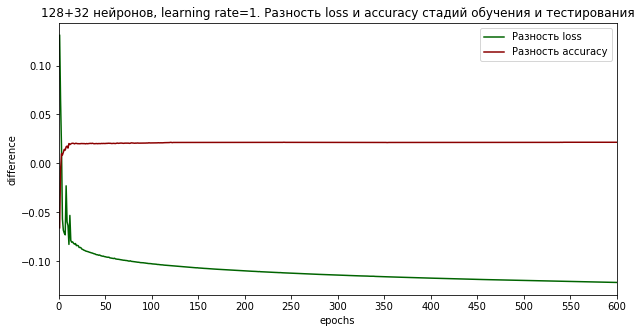

In [75]:
fog, ax = plt.subplots(figsize=(10,5))

ax.plot(range(1,n_epochs+1), [train_loss[0]-test_loss[0] for test_loss,train_loss in zip(test_loss_history_2L, train_loss_history_2L)], label='Разность loss', ls='-', color='darkgreen')
ax.plot(range(1,n_epochs+1), [train_acc[0]-test_acc[0] for test_acc,train_acc in zip(test_accuracy_history_2L, train_accuracy_history_2L)], label='Разность accuracy', ls='-', color='darkred')
ax.set_xlim(1,n_epochs);
ax.set_xticks(range(0,n_epochs+1,50));

ax.set_title('128+32 нейронов, learning rate=1. Разность loss и accuracy стадий обучения и тестирования', fontsize=12);
ax.legend();

ax.set_xlabel('epochs')
ax.set_ylabel('difference');

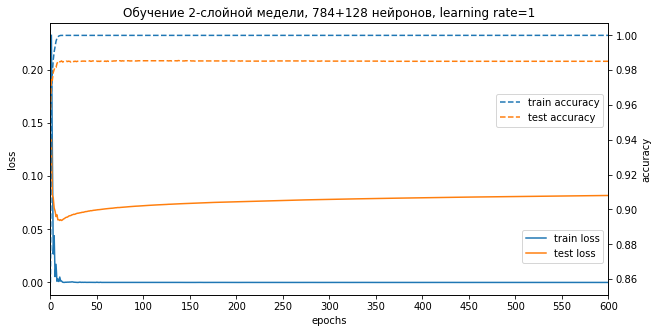

In [79]:
fog, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(range(1,n_epochs+1), [loss[1] for loss in train_loss_history_2L], label='train loss')
ax1.plot(range(1,n_epochs+1), [loss[1] for loss in test_loss_history_2L], label='test loss')

ax2 = ax1.twinx()
ax2.plot(range(1,n_epochs+1), [acc[1] for acc in train_accuracy_history_2L], label='train accuracy', ls='--')
ax2.plot(range(1,n_epochs+1), [acc[1] for acc in test_accuracy_history_2L], label='test accuracy', ls='--')

ax1.legend(loc='lower right', bbox_to_anchor=(0.5, 0.1, 0.5, 0.5))
ax2.legend(loc='lower right', bbox_to_anchor=(0.5, 0.6, 0.5, 0.5))
ax1.set_title('Обучение 2-слойной медели, 784+128 нейронов, learning rate=1', fontsize=12);
ax1.set_xlim(1,n_epochs);
ax1.set_xticks(range(0,n_epochs+1,50));

ax1.set_xlabel('epochs');
ax1.set_ylabel('loss');
ax2.set_ylabel('accuracy');

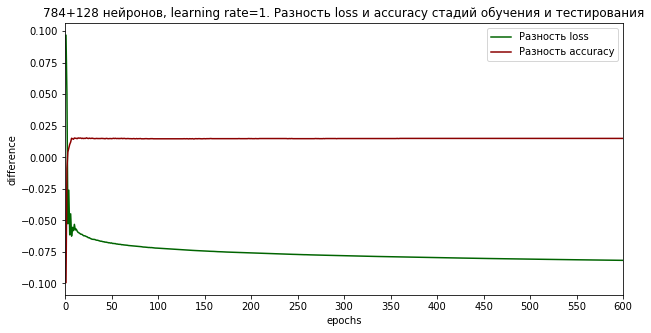

In [76]:
fog, ax = plt.subplots(figsize=(10,5))

ax.plot(range(1,n_epochs+1), [train_loss[1]-test_loss[1] for test_loss,train_loss in zip(test_loss_history_2L, train_loss_history_2L)], label='Разность loss', ls='-', color='darkgreen')
ax.plot(range(1,n_epochs+1), [train_acc[1]-test_acc[1] for test_acc,train_acc in zip(test_accuracy_history_2L, train_accuracy_history_2L)], label='Разность accuracy', ls='-', color='darkred')
ax.set_xlim(1,n_epochs);
ax.set_xticks(range(0,n_epochs+1,50));

ax.set_title('784+128 нейронов, learning rate=1. Разность loss и accuracy стадий обучения и тестирования', fontsize=12);
ax.legend();

ax.set_xlabel('epochs')
ax.set_ylabel('difference');

### Двухслойные модели с разным количеством слоёв - 128+32 и 784+128.
### Модель с большим количеством нейронов показала чуть большую точность распознавания - около 99% против 98-ми.
### Обе модели, как и однослойные модели, начали переобучаться примерно с 15-ой эпохи - начался рост функции потерь на тестовой выборке.